In [1]:
from config import cfg
import pandas as pd
import numpy as np
from models import AudioReconstructor, PesudoSNRGenerator
from utils import sound_separation, vizualize_spectrogram, write_as_wav
from scipy.io import wavfile
import IPython.display as ipd
import optuna

## Load and Visualize Audio

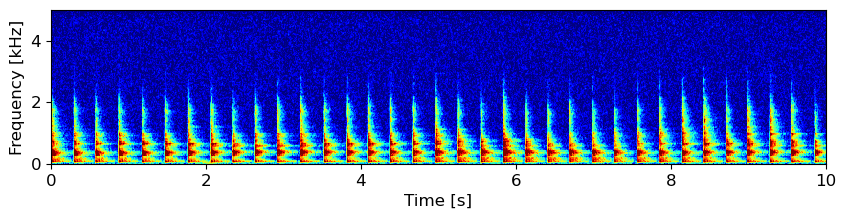

In [10]:
_, ground_truth = wavfile.read('AudioExamples/ground_truth_0.wav')
ground_truth = ground_truth.T
ipd.display(ipd.Audio(ground_truth[0], rate=cfg.sr))
vizualize_spectrogram(ground_truth[0], end_time=10, max_freq=5, fig_size=[10,2], font_size=12, cut_percent=5)

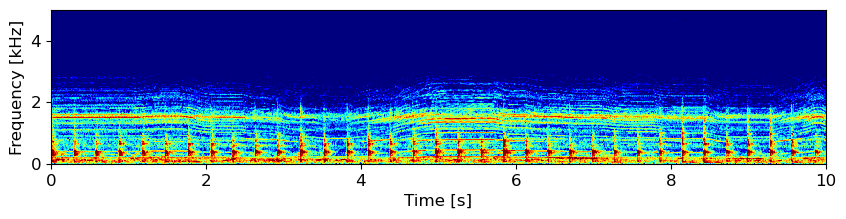

In [11]:
_, mix_audio = wavfile.read('AudioExamples/mix_audio_0.wav')
mix_audio = mix_audio.T
ipd.display(ipd.Audio(mix_audio[0], rate=cfg.sr))
vizualize_spectrogram(mix_audio[0], end_time=10, max_freq=5, fig_size=[10,2], font_size=12, cut_percent=5)

## Zero-shot Denoising

In [12]:
ar_model = AudioReconstructor()
se_model = PesudoSNRGenerator()

tgt_class = 'continuous tapping'
pesudo_snr_before = se_model.estimate_snr(mix_audio[0].copy(), tgt_class)

results = []
def objective(trial):
	n_sources = trial.suggest_int('n_sources', 2, 4) 
	n_basis = trial.suggest_int('n_basis', 4, 8)

	try:
		separated_amples = sound_separation(mix_audio.copy(), n_sources, n_basis, n_iter=50, n_fft=4096)
		pred_audio, _ = ar_model.reconstruct_audio(separated_amples, tgt_class)
		pesudo_snr_after = se_model.estimate_snr(pred_audio.copy(), tgt_class)
		pesudo_snr_imp = pesudo_snr_after - pesudo_snr_before
	except Exception as e:
		print(e)
		pesudo_snr_imp = 0
		pred_audio = np.zeros(1)
	
	results.append({
		'n_basis': n_basis, 
		'n_sources': n_sources, 
		'pesudo_snr_imp': pesudo_snr_imp,
		'mix_audio': mix_audio[0],
		'pred_audio': pred_audio,
	})
	trial.set_user_attr('pesudo_snr_imp', pesudo_snr_imp)
	return pesudo_snr_imp

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
result_df = pd.DataFrame(results)

[I 2025-06-09 14:29:39,816] A new study created in memory with name: no-name-0fd68437-720b-4746-9165-fe407aaa4900
[I 2025-06-09 14:30:02,599] Trial 0 finished with value: 0.10500001907348633 and parameters: {'n_sources': 3, 'n_basis': 4}. Best is trial 0 with value: 0.10500001907348633.
[I 2025-06-09 14:30:32,290] Trial 1 finished with value: 0.07100000977516174 and parameters: {'n_sources': 3, 'n_basis': 7}. Best is trial 0 with value: 0.10500001907348633.
[I 2025-06-09 14:31:17,982] Trial 2 finished with value: 0.06600001454353333 and parameters: {'n_sources': 4, 'n_basis': 8}. Best is trial 0 with value: 0.10500001907348633.
[I 2025-06-09 14:31:45,038] Trial 3 finished with value: 0.029000014066696167 and parameters: {'n_sources': 3, 'n_basis': 6}. Best is trial 0 with value: 0.10500001907348633.
[I 2025-06-09 14:32:06,231] Trial 4 finished with value: 0.12600001692771912 and parameters: {'n_sources': 2, 'n_basis': 8}. Best is trial 4 with value: 0.12600001692771912.
[I 2025-06-09 1

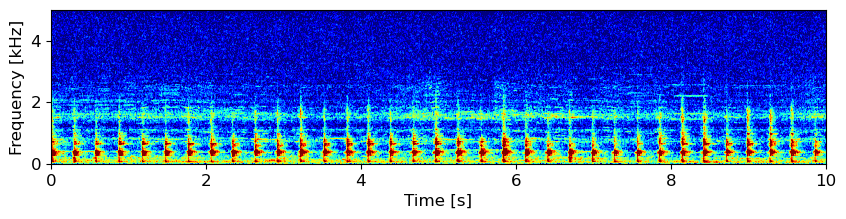

In [15]:
pred_audio = result_df[lambda x:x['pesudo_snr_imp'] == x['pesudo_snr_imp'].max()]['pred_audio'].values[0]
ipd.display(ipd.Audio(pred_audio, rate=cfg.sr))
vizualize_spectrogram(pred_audio, end_time=10, max_freq=5, fig_size=[10,2], font_size=12, cut_percent=5)